In [1]:
import gps_particle_data
import wget
import os
import numpy as np 
import time
import json
import sys
import math
from datetime import datetime, timedelta, date
from itertools import compress
from random import randint
import urllib2
import aacgmv2
import scipy
import matplotlib
from matplotlib import gridspec
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
start_time = time.clock()
start_date = datetime(2016,1,1,0,0,0);
end_date = datetime(2017,1,1,0,0,0);
satlist = [56]
L_thres = np.arange(0.01,0.21,0.01)
#alt = np.arange(0.0,805.0,5.0) # 0 to 800 in km

ms = gps_particle_data.meta_search(satlist); 

ms.load_data(start_date,end_date);
print "--- %s seconds ---" % (time.clock() - start_time)


Loading data for satellite  56
File : https://www.ngdc.noaa.gov/stp/space-weather/satellite-data/satellite-systems/gps/data/ns56/ns56_160103_v1.03.ascii
File : https://www.ngdc.noaa.gov/stp/space-weather/satellite-data/satellite-systems/gps/data/ns56/ns56_160110_v1.03.ascii
File : https://www.ngdc.noaa.gov/stp/space-weather/satellite-data/satellite-systems/gps/data/ns56/ns56_160117_v1.03.ascii
File : https://www.ngdc.noaa.gov/stp/space-weather/satellite-data/satellite-systems/gps/data/ns56/ns56_160124_v1.03.ascii
File : https://www.ngdc.noaa.gov/stp/space-weather/satellite-data/satellite-systems/gps/data/ns56/ns56_160131_v1.03.ascii
File : https://www.ngdc.noaa.gov/stp/space-weather/satellite-data/satellite-systems/gps/data/ns56/ns56_160207_v1.03.ascii
File : https://www.ngdc.noaa.gov/stp/space-weather/satellite-data/satellite-systems/gps/data/ns56/ns56_160214_v1.03.ascii
File : https://www.ngdc.noaa.gov/stp/space-weather/satellite-data/satellite-systems/gps/data/ns56/ns56_160221_v1.0

In [3]:
start_time = time.clock()
#Get earthquakes for given conditions
eq_s = gps_particle_data.earthquake_search(start_date,end_date, min_magnitude=4,min_lat=-90,max_lat=90,min_lon=-180,max_lon=180)
#Calculate L-shells of the earthquakes
L_shells = eq_s.get_L_shells(400.0)
#EQ datetimes
eq_datetimes = eq_s.get_datetimes()
print "--- %s seconds ---" % (time.clock() - start_time)

--- 7.9552399366 seconds ---


In [4]:
n = 56

#find mean and standard deviation for given period of time
output_data = ms.get_all_data_by_satellite()
signame = 'rate_electron_measured';
signal = np.asarray(output_data[n][signame])[:,2];
avg = np.mean(signal)
stddev = np.std(signal)
print avg, stddev

842.021599411 1657.60473582


In [5]:
start_time = time.clock()
r = output_data[n][signame]
#calculations performed w.r.t. channel 2 (electron rates)
ch2 = np.asarray(r)[:,2]
#find difference between signal and average
sig_dif = np.subtract(ch2, avg)
#ratio in terms of std dev
ratio = np.divide(sig_dif, stddev)

indices = []
burst_indices = ratio>4

#get indices of the signal points with sig_dif value > 4 sigma
for i in range(len(burst_indices)):
    if burst_indices[i] == True:
        indices.append(i)
print "--- %s seconds ---" % (time.clock() - start_time)        

--- 0.158165208363 seconds ---


In [10]:
start_time = time.clock()
#L_thres = [0.04,0.07,0.10,0.13,0.16,0.19]
L_thres = [0.50,1.00,2.00]
conflvl = []

for lthres in L_thres:
    start = time.clock()
    
    # setup the current file we are using
    # removes deciaml point for lthres
    slthres = ''.join(e for e in str(lthres) if e.isalnum())
    # file...
    current_file = 'Ltemp_' + str(n) + '_' + slthres + '.ascii'
    
    print '=== %s' % (current_file)

    his_data = [] #not sure this one is necessary?
    dday = output_data[n]['decimal_day']
    ls = output_data[n]['L_shell']
    #trying to match EQ and PB based on two conditions: delta T < 0.5 days and delta L (in this case) < 1
    for i in indices:
        for j in range(len(L_shells)):
            date = datetime.strptime(str(eq_datetimes[j])[:10], "%Y-%m-%d")
            int_diy = date.timetuple().tm_yday
            rest = (float(str(eq_datetimes[j])[11:13])/24) + (float(str(eq_datetimes[j])[14:16])/(24*60))+(float(str(eq_datetimes[j])[17:19])/(24*3600))
            diy = int_diy + rest
            del_T = dday[i]-diy
            del_L = ls[i]-L_shells[j]
            if abs(del_L) < lthres and  abs(del_T) < 0.5: # lthres use to be 1.
                dT = del_T*24
                #print dT, ls[i]
                #append it to the file
                with open(current_file, 'a') as f:
                    np.savetxt(f, dT)

print " "
print "--- %s seconds ---" % (time.clock() - start_time) 

=== Ltemp_56_05.ascii


C:\Anaconda35\envs\py27\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in absolute
C:\Anaconda35\envs\py27\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less


=== Ltemp_56_10.ascii
=== Ltemp_56_20.ascii
 
--- 1958.37652 seconds ---


=== Ltemp_56_001.ascii
dL value: 0.01 --- Conf Level: 2.3182480119
Nmax, Nbg, sig, nsig
2 0.357142857143 0.610285981808 2.3182480119
1
=== Ltemp_56_002.ascii
dL value: 0.02 --- Conf Level: 3.07701383181
Nmax, Nbg, sig, nsig
6 1.07142857143 1.75109295316 3.07701383181
1
=== Ltemp_56_003.ascii
dL value: 0.03 --- Conf Level: 2.97797612074
Nmax, Nbg, sig, nsig
9 1.85714285714 2.7994168489 2.97797612074
2
=== Ltemp_56_004.ascii
dL value: 0.04 --- Conf Level: 2.84524420822
Nmax, Nbg, sig, nsig
10 2.21428571429 3.27716278484 2.84524420822
2
=== Ltemp_56_005.ascii
dL value: 0.05 --- Conf Level: 3.14153686753
Nmax, Nbg, sig, nsig
10 1.95 2.97447474355 3.14153686753
1
=== Ltemp_56_006.ascii
dL value: 0.06 --- Conf Level: 2.82872936592
Nmax, Nbg, sig, nsig
10 2.3 3.28785644455 2.82872936592
3
=== Ltemp_56_007.ascii
dL value: 0.07 --- Conf Level: 3.07926089327
Nmax, Nbg, sig, nsig
13 2.75 3.9984371947 3.07926089327
4
=== Ltemp_56_008.ascii
dL value: 0.08 --- Conf Level: 3.23775959336
Nmax, Nbg, si

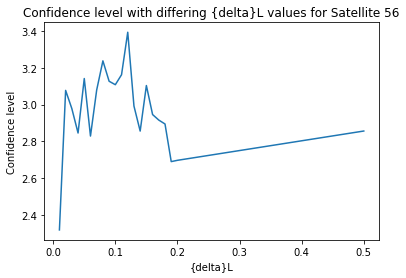

In [15]:
L_thres = np.arange(0.01,0.21,0.01)
L_thres = np.append(L_thres, [0.50])
n=56
start_time = time.clock()
conflvl = []

for lthres in L_thres:
    # setup the current file we are using
    slthres = ''.join(e for e in str(lthres) if e.isalnum())
    current_file = 'Ltemp_' + str(n) + '_' + slthres + '.ascii'
    
    print '=== %s' % (current_file)
    
    curdata = np.loadtxt(current_file)
    #convert the data into histogram bins.
    bins = np.arange(min(curdata), max(curdata)+1)
    hist, bin_edges = np.histogram(curdata,bins)
    
    #print hist # number of items per bin
    #print bin_edges # interval of each bin.
    
    # n{sig} = (Nmax - Nbg/{sig})     taken from S. Yu Aleksandrin et al.: High-energy charged particle bursts
    
    Nmax = max(hist)
    Nbg = np.mean(hist)
    sig = np.std(hist) #Should be from the background value...
    
    #nsig = (Nmax - Nbg/sig) # Confidence between 10~70 :: approx the plot we want.
    nsig = (Nmax - Nbg/sig)/sig # -- We want it in a number of standard deviations...
    #nsig = (max(hist) - min(hist[hist!=0]))/float(len(hist))
    #nsig = (Nmax - Nbg)/sig # Confidence between 2~2.5 :: wrong shape.
    
    
    conflvl.append(nsig)
    
    ourstring = 'dL value: %s --- Conf Level: %s' % (lthres, nsig)
    print ourstring
    print 'Nmax, Nbg, sig, nsig'
    print Nmax, Nbg, sig, nsig
    print min(hist[hist!=0])

plt.plot(L_thres, conflvl)
plttitle = 'Confidence level with differing {delta}L values for Satellite %s' % (n)
plt.title(plttitle)
plt.xlabel('{delta}L')
plt.ylabel('Confidence level')

print " "
print "--- %s seconds ---" % (time.clock() - start_time) 

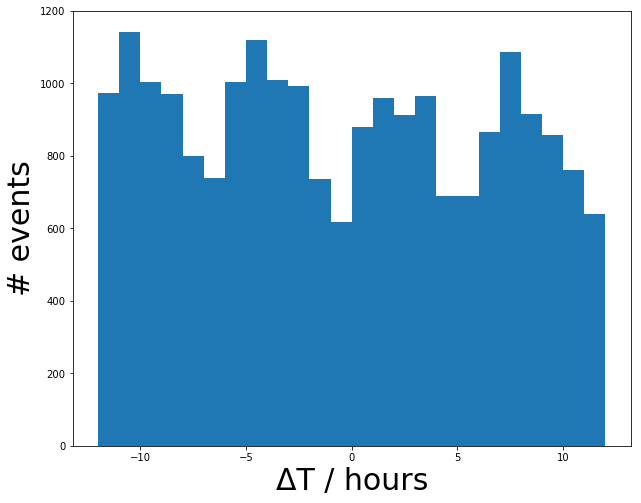

In [10]:
#plot the data so far
fig = plt.figure(figsize=(10, 8))
his = np.loadtxt('temp_cor56_largeL.ascii')
plt.hist(his, bins = np.arange(min(his), max(his)+1))
plt.xlabel(u'ΔT / hours', fontsize  = 30)
plt.ylabel('# events', fontsize = 30)
plt.show()

In [ ]:
print Nmax
print Nbg
print sig
print nsig